# Benchmark



In [5]:
import numpy as np
import cvxpy as cp
from scipy.sparse import block_diag
import matplotlib.pyplot as plt

print(f'cvxpy version: {cp.__version__}')

cvxpy version: 1.3.0


In [6]:
E_dim = 70e3 # [Pa]
E = 70e3 / E_dim # [-] Young's modulus
nu = 0.3 # [-] Poisson's ratio 
sig0 = 250 / E_dim # [-] yield strength
Et = E/100. # [-] tangent modulus
H = E*Et/(E-Et) # [-] hardening modulus

l, m = lambda_, mu_ = E*nu/(1+nu)/(1-2*nu), E/2/(1+nu)   

# Elasticity stiffness matrix
C = np.array([[l+2*m, l, l, 0],
              [l, l+2*m, l, 0],
              [l, l, l+2*m, 0],
              [0, 0, 0, 2*m]])
S = np.linalg.inv(C)

def criterion(sig:cp.expressions.variable.Variable, p:cp.expressions.variable.Variable):
    """Creates a constraint for convex optimization problem in the form of von Mises criterion.
    
    Args:
        sig: A cvxpy variable of 4-dimensional Voigt vector of stresses
        p: A cvxpy variable of cumulated equivalent plastic strain
    
    Returns:    
        A list with a semi-definitive conic constraint in the form of von Mises yield criterion
    """
    N = p.size
    dev = np.array([[2/3., -1/3., -1/3., 0],
                    [-1/3., 2/3., -1/3., 0],
                    [-1/3., -1/3., 2/3., 0],
                    [0, 0, 0, 1.]])

    sig0_vec = np.repeat(sig0, N)
    s = dev @ sig

    return [np.sqrt(3/2)*cp.norm(s, axis=0) <= sig0_vec + p * H]

In [7]:
deps_np = np.load('delta_epsilon.npy')
deps_np.shape
n_quadrature_points = int(deps_np.size/4)
n_quadrature_points

4434

In [8]:
N = patch_size = 500
# N_patches = int(n_quadrature_points/patch_size)
# residue_size = n_quadrature_points % patch_size
# deps_values = deps_np[:4*(n_quadrature_points - residue_size)].reshape((-1, patch_size, 4))
deps_values = deps_np[:4*N].reshape((-1, patch_size, 4))
deps_values.shape

(1, 500, 4)

In [9]:
deps = cp.Parameter((4, N), name='deps')
sig_old = cp.Parameter((4, N), name='sig_old')
sig_elas = sig_old + C @ deps
sig = cp.Variable((4, N), name='sig')

p_old = cp.Parameter((N,), nonneg=True, name='p_old')
p = cp.Variable((N,),nonneg=True, name='p')

sig_old.value = np.zeros((4, N))
deps.value = np.zeros((4, N))
p_old.value = np.zeros((N,))
deps.value = deps_values[0,:].T

delta_sig = sig - sig_elas

# energy = []
# for i in range(N):
#     energy.append(cp.quad_form(delta_sig[:, i], S))
# target_expression = cp.sum(cp.hstack(energy)) + material.yield_criterion.H * cp.sum_squares(self.p - self.p_old)
# energy = cp.sum(cp.diag(delta_sig.T @ S_sparsed @ delta_sig))
# target_expression = 0.5*elastic_energy + 0.5*material.yield_criterion.H * cp.sum_squares(self.p - self.p_old)

D = H * np.eye(N)
S_sparsed = block_diag([S for _ in range(N)])
delta_sig_vector = cp.reshape(delta_sig, (N*4))

elastic_energy = cp.quad_form(delta_sig_vector, S_sparsed, assume_PSD=True)
target_expression = 0.5*elastic_energy + 0.5*cp.quad_form(p - p_old, D)

constrains = criterion(sig, p) 

opt_problem = cp.Problem(cp.Minimize(target_expression), constrains)

In [10]:
conic_solver = 'SCS'
tol_conic_solver = 1e-12
conic_solver_params = {}

if conic_solver == 'SCS':
    conic_solver_params = {
        'eps': tol_conic_solver, 
        'eps_abs': tol_conic_solver, 
        'eps_rel': tol_conic_solver,
        'eps_infeas': tol_conic_solver,
    }
elif conic_solver == 'ECOS':
    conic_solver_params = {'abstol': tol_conic_solver, 'reltol': tol_conic_solver}

In [11]:
opt_problem.solve(solver=conic_solver, requires_grad=False, ignore_dpp=False, verbose=True, **conic_solver_params)


                                     CVXPY                                     
                                     v1.3.0                                    
(CVXPY) May 01 02:33:56 PM: Your problem has 2500 variables, 1 constraints, and 4500 parameters.
(CVXPY) May 01 02:33:56 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 01 02:33:56 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 01 02:33:56 PM: Compiling problem (target solver=SCS).
(CVXPY) May 01 02:33:56 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> SCS
(CVXPY) May 01 02:33:56 PM: Applying reduction Dcp2Cone
(CVXPY) May 01 02:33:56 PM: Applying reduction CvxAttr2Constr
(CVXP

7.860515480576927e-23

In [16]:
sig_elas.value

array([[ 7.48995198e-04,  7.40117626e-04,  7.45896877e-04, ...,
         9.53323654e-04,  8.52971147e-04,  8.65714981e-04],
       [-1.34790679e-05, -4.70451402e-06, -1.06224255e-05, ...,
        -2.17705393e-04, -1.17758964e-04, -1.30626990e-04],
       [ 2.20654839e-04,  2.20623934e-04,  2.20582335e-04, ...,
         2.20685478e-04,  2.20563655e-04,  2.20526397e-04],
       [-2.87981150e-06, -2.80341237e-06, -1.15848490e-05, ...,
        -1.61584591e-04, -2.36033925e-04, -2.28049073e-04]])

In [17]:
np.min(delta_sig.value)

-6.461844948013606e-17

In [8]:
def run_test(N:int, conic_solver:str):
    deps_values = deps_np[:4*N].reshape((-1, N, 4))

    deps = cp.Parameter((4, N), name='deps')
    sig_old = cp.Parameter((4, N), name='sig_old')
    sig_elas = sig_old + C @ deps
    sig = cp.Variable((4, N), name='sig')
    p_old = cp.Parameter((N,), nonneg=True, name='p_old')
    p = cp.Variable((N,),nonneg=True, name='p')

    sig_old.value = np.zeros((4, N))
    deps.value = np.zeros((4, N))
    p_old.value = np.zeros((N,))
    deps.value = deps_values[0,:].T

    delta_sig = sig - sig_elas
    D = H * np.eye(N)
    S_sparsed = block_diag([S for _ in range(N)])
    delta_sig_vector = cp.reshape(delta_sig, (N*4))

    elastic_energy = cp.quad_form(delta_sig_vector, S_sparsed, assume_PSD=True)
    target_expression = 0.5*elastic_energy + 0.5*cp.quad_form(p - p_old, D)
    constrains = criterion(sig, p) 

    opt_problem = cp.Problem(cp.Minimize(target_expression), constrains)

    conic_solver = 'SCS'
    tol_conic_solver = 1e-12
    conic_solver_params = {}

    if conic_solver == 'SCS':
        conic_solver_params = {
            'eps': tol_conic_solver, 
            'eps_abs': tol_conic_solver, 
            'eps_rel': tol_conic_solver,
            'eps_infeas': tol_conic_solver,
        }
    elif conic_solver == 'ECOS':
        conic_solver_params = {'abstol': tol_conic_solver, 'reltol': tol_conic_solver}

    opt_problem.solve(solver=conic_solver, requires_grad=False, ignore_dpp=False, verbose=False, **conic_solver_params)

    return opt_problem


In [9]:
def run_benchmark():
    N_list = np.array([1, 10, 100, 250, 500, 1000])
    T_compil = {'SCS': [], 'ECOS': []}

    for solver in T_compil:
        print(f'Solver: {solver}')
        for N in N_list:
            solved_prob = run_test(N, solver)
            T_compil[solver].append(solved_prob._compilation_time)
            print(f'\tproblem dim: {N}\n\tsolution time: {solved_prob._solve_time}\n\tcompilation time: {solved_prob._compilation_time}\n')
    
    return N_list, T_compil

In [10]:
benchmark_results = run_benchmark()

Solver: SCS
	problem dim: 1
	solution time: 0.0006756782531738281
	compilation time: 0.022351980209350586

	problem dim: 10
	solution time: 0.0025262832641601562
	compilation time: 0.026265621185302734

	problem dim: 100
	solution time: 0.008549690246582031
	compilation time: 0.12494444847106934

	problem dim: 250
	solution time: 0.021039724349975586
	compilation time: 0.743912935256958

	problem dim: 500
	solution time: 0.041141510009765625
	compilation time: 3.803076982498169

	problem dim: 1000
	solution time: 0.1142575740814209
	compilation time: 43.402533531188965

Solver: ECOS
	problem dim: 1
	solution time: 0.0011513233184814453
	compilation time: 0.05123281478881836

	problem dim: 10
	solution time: 0.0016937255859375
	compilation time: 0.05542397499084473

	problem dim: 100
	solution time: 0.009916543960571289
	compilation time: 0.15029692649841309

	problem dim: 250
	solution time: 0.02436208724975586
	compilation time: 0.7009320259094238

	problem dim: 500
	solution time: 0.

In [13]:
def show_results(N_list, T_comp):
    for solver in T_comp:
        plt.plot(5*N_list, T_comp[solver], "-o", label=solver)
    plt.xlabel("Dimension of vectorized conic problem")
    plt.ylabel("Compilation time")
    plt.legend()
    plt.show()

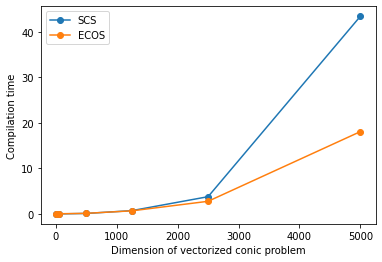

In [14]:
show_results(*benchmark_results)